In [1]:
%load_ext autoreload
%autoreload 2

import pathlib
import pickle
import os

import numpy as np
import pandas as pd

from scipy import signal

import mne
from matplotlib import pyplot as plt

import constants
import dataset
import folders
import iter_topography_fork
import analysis_and_plotting_functions as aps

In [2]:
plt.rcParams['figure.figsize'] = [12,6]

In [3]:
# Load dataset into memory (if short of memory, use preload=False)
ds = dataset.DatasetReader(data_path=folders.database_path, preload=True)

99 percent complete

C:\Projects\Work\sensortech\brlbci\brlbci_analysis\analysis_and_plotting_functions.py:245: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  step_down_p=step_down_p


[............................................................] 100.00%  |
[0.001]
Mean F-score for cluster 10.059847557710802
Cluster channels ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']


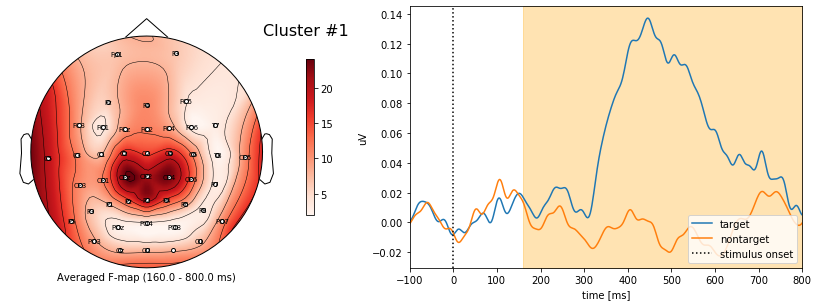

In [4]:
# target vs nontarget -- for illiustration of the method
target = []
nontarget = []
condition_names = ['target', 'nontarget']

for user in set(ds.markup['user']):
    subset_user= ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8')
                                ]
    ep=aps.subset(ds, subset_user)

    target.append(ep['target'])
    nontarget.append(ep['nontarget'])

X = [np.array([a.data.T for a in target]), 
     np.array([a.data.T for a in nontarget])]
info = nontarget[0].info
times = nontarget[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times,  condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=0, n_jobs=1)

In [ ]:
# nontarget right vs left for sighted
right_hand = []
left_hand = []
condition_names = ['left_hand', 'right_hand']

for user in set(ds.markup.loc[ds.markup['blind'] == 0]['user']): 
    subset_right = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8') &
                                (ds.markup['finger'].isin([7,6,5,4]))
                                ]

    subset_left = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8') &
                                (ds.markup['finger'].isin([0,1,2,3]))
                                ]

    right_hand.append(aps.subset(ds, subset_right)['nontarget'].crop(tmax=0.3, tmin=0))
    left_hand.append(aps.subset(ds, subset_left)['nontarget'].crop(tmax=0.3, tmin=0))

X = [np.array([a.data.T for a in left_hand]), 
    np.array([a.data.T for a in right_hand])]
info = left_hand[0].info
times = left_hand[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times,  condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=0, n_jobs=4)

In [ ]:
# nontarget right vs left for blind
right_hand = []
left_hand = []
condition_names = ['left_hand', 'right_hand']

for user in set(ds.markup.loc[ds.markup['blind'] == 1]['user']): 
    subset_right = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8') &
                                (ds.markup['finger'].isin([7,6,5,4]))
                                ]

    subset_left = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8') &
                                (ds.markup['finger'].isin([0,1,2,3]))
                                ]

    right_hand.append(aps.subset(ds, subset_right)['nontarget'].crop(tmax=0.3, tmin=0))
    left_hand.append(aps.subset(ds, subset_left)['nontarget'].crop(tmax=0.3, tmin=0))

X = [np.array([a.data.T for a in left_hand]), 
    np.array([a.data.T for a in right_hand])]
info = left_hand[0].info
times = left_hand[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times,  condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=0, n_jobs=4)

In [ ]:
# nontarget right vs left for all
right_hand = []
left_hand = []
condition_names = ['left_hand', 'right_hand']

for user in set(ds.markup['user']):
    
    subset_right = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8') &
                                (ds.markup['finger'].isin([7,6,5,4]))
                                ]

    subset_left = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8') &
                                (ds.markup['finger'].isin([0,1,2,3]))
                                ]

    right_hand.append(aps.subset(ds, subset_right)['nontarget'].crop(tmax=0.3, tmin=0))
    left_hand.append(aps.subset(ds, subset_left)['nontarget'].crop(tmax=0.3, tmin=0))


X = [np.array([a.data.T for a in left_hand]), 
    np.array([a.data.T for a in right_hand])]
info = left_hand[0].info
times = left_hand[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times,  condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=0, n_jobs=4)

In [7]:
# target blind vs sighted
blind = []
sighted = []
condition_names = ['blind', 'sighted']

for user in set(ds.markup.loc[ds.markup['blind'] == 1]['user']):
    subset_blind = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8')
                                ]
    blind.append(aps.subset(ds, subset_blind)['delta'].crop(tmax=0.8, tmin=0))

for user in set(ds.markup.loc[ds.markup['blind'] == 0]['user']):
    subset_sighted = ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'brl_static6_all8')
                                ]
    sighted.append(aps.subset(ds, subset_sighted)['delta'].crop(tmax=0.8, tmin=0))

X = [np.array([a.data.T for a in blind]), 
    np.array([a.data.T for a in sighted])]
info = blind[0].info
times = blind[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times, condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=1, n_jobs=4)

[                                                            ]   0.00%  |
No significant clusters found


[............................................................] 100.00%  |
[0.005]
Mean F-score for cluster 3.020128757636528
Cluster channels ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C1', 'Cz', 'C2']


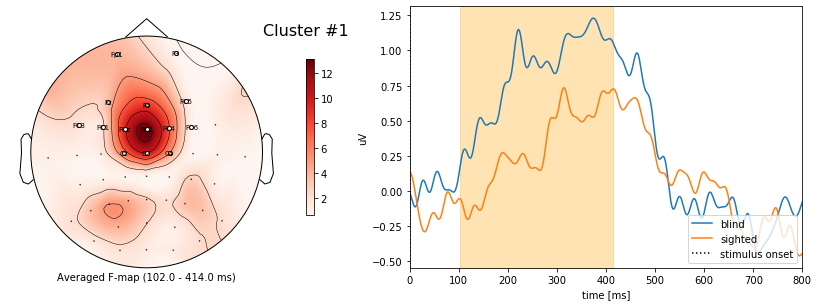

In [6]:
# target blind vs sighted - letter averaged
blind = []
sighted = []
condition_names = ['blind', 'sighted']


for user in set(ds.markup.loc[ds.markup['blind'] == 1]['user']):
    for session in set(ds.markup.loc[ds.markup['user'] == user]['session_id']):
        subset_blind = ds.markup.loc[   (ds.markup['user'] == user) &
                                        (ds.markup['reg'] == 'brl_static6_all8') &
                                        (ds.markup['session_id'] == session)
                                    ]
        blind.append(aps.subset(ds, subset_blind)['delta'].crop(tmax=0.8, tmin=0))

for user in set(ds.markup.loc[ds.markup['blind'] == 0]['user']):
    for session in set(ds.markup.loc[ds.markup['user'] == user]['session_id']):
        subset_sighted = ds.markup.loc[ (ds.markup['user'] == user) &
                                        (ds.markup['reg'] == 'brl_static6_all8') &
                                        (ds.markup['session_id'] == session)
                                    ]
        sighted.append(aps.subset(ds, subset_sighted)['delta'].crop(tmax=0.8, tmin=0))


X = [np.array([a.data.T for a in blind]), 
    np.array([a.data.T for a in sighted])]
info = blind[0].info
times = blind[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times, condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=1, n_jobs=1, cutoff_pval=0.05)

[............................................................] 100.00%  |
[0.001]
Mean F-score for cluster 4.177607709882377
Cluster channels ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']


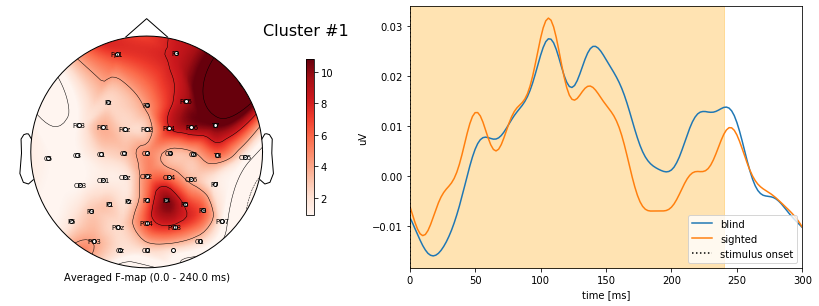

In [11]:
# nontarget blind vs sighted - letter averaged
blind = []
sighted = []
condition_names = ['blind', 'sighted']


for user in set(ds.markup.loc[ds.markup['blind'] == 1]['user']):
    for session in set(ds.markup.loc[ds.markup['user'] == user]['session_id']):
        subset_blind = ds.markup.loc[   (ds.markup['user'] == user) &
                                        (ds.markup['reg'] == 'brl_static6_all8') &
                                        (ds.markup['session_id'] == session)
                                    ]
        blind.append(aps.subset(ds, subset_blind)['nontarget'].crop(tmax=0.3, tmin=0))

for user in set(ds.markup.loc[ds.markup['blind'] == 0]['user']):
    for session in set(ds.markup.loc[ds.markup['user'] == user]['session_id']):
        subset_sighted = ds.markup.loc[ (ds.markup['user'] == user) &
                                        (ds.markup['reg'] == 'brl_static6_all8') &
                                        (ds.markup['session_id'] == session)
                                    ]
        sighted.append(aps.subset(ds, subset_sighted)['nontarget'].crop(tmax=0.3, tmin=0))


X = [np.array([a.data.T for a in blind]), 
    np.array([a.data.T for a in sighted])]
info = blind[0].info
times = blind[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times, condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=1, n_jobs=1, cutoff_pval=0.05)

In [16]:
# first vs nonfirst
condition_names = ['one', 'not_one']

ONE = []
NOTONE = []
for user in sorted(set(ds.markup.user)):
    subset_one = []
    subset_two = []
    ss_nt = ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8') &
              (ds.markup['is_target'] == 0) &
              (ds.markup['user'] == user)
             ]
    for session_id in sorted(set(ds.markup.session_id)):
        ss2 = ds.markup.loc[        (ds.markup['reg'] == 'brl_static6_all8') &
                                    (ds.markup['is_target'] == 1) &
                                    (ds.markup['user'] == user) &
                                    (ds.markup.session_id == session_id)
                            ]
    
        subset_one.append(ss2.iloc[0])
        subset_two.append(ss2.iloc[9])
        
    snt = pd.DataFrame(ss_nt)
    subset_one = pd.DataFrame(subset_one)
    subset_one = pd.concat([snt, subset_one])

    subset_two = pd.DataFrame(subset_two)
    subset_two = pd.concat([snt, subset_two])
    
    
    ONE.append(aps.subset(ds, subset_one)['delta'].crop(tmax=0.8, tmin=0))
    NOTONE.append(aps.subset(ds, subset_two)['delta'].crop(tmax=0.8, tmin=0))
    

X = [np.array([a.data.T for a in ONE]), 
    np.array([a.data.T for a in NOTONE])]
info = ONE[0].info
times = ONE[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times, condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=1, n_jobs=1, cutoff_pval=0.05)

[............................................................] 100.00%  |
No significant clusters found
